# Import libraries

In [5]:
# import system libs
import os
import time
import shutil 
import pathlib

import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D,Flatten,Dense,Activation,Dropout,BatchNormalization
from tensorflow.keras import regularizers

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Import Dataset

In [6]:
path1 = []
path2 = []
path3 = []
path4 = []
for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Non Demented'):
    for filename in filenames:
        path1.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Mild Dementia'):
    for filename in filenames:
        path2.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Moderate Dementia'):
    for filename in filenames:
        path3.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk('/kaggle/input/imagesoasis/Data/Very mild Dementia'):
    for filename in filenames:
        path4.append(os.path.join(dirname, filename))  

In [7]:
paths=[]
paths.append(path1)
paths.append(path2)
paths.append(path3)
paths.append(path4)

In [8]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

In [9]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

In [10]:
data_dir = '/kaggle/input/imagesoasis/Data'


# Get splitted data
train_df, valid_df, test_df = split_data(data_dir)

# Get Generators
batch_size = 40
train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

Found 69149 validated image filenames belonging to 4 classes.
Found 8644 validated image filenames belonging to 4 classes.
Found 8644 validated image filenames belonging to 4 classes.


In [11]:
def show_image(gen):
    
    '''
    This fuction take the data generator and show sample of 
    the images
    '''
    # return classes, images to be displayed
    g_dict = gen.class_indices #define dictionary{'class':index}
    classes = list(g_dict.keys()) #define list of dictionary's kays(classes),classes names: string
    images, labels = next(gen) # get a batch size samples from the generator

    #calculate number of displayed samples
    length = len(labels) # length of batch size
    sample = min(length, 25) # check if sample less than 25 images

    
    plt.figure(figsize=(20,20))
    for i in range(sample):
        plt.subplot(5, 5, i+1)
        image = images[i]/255 # scales data to range(0-255)
        plt.imshow(image)
        index = np.argmax(labels[i]) # get image index
        class_name = classes[index] # get class of image
        plt.title(class_name, color='blue', fontsize=12)
        plt.axis('off')
    plt.show()

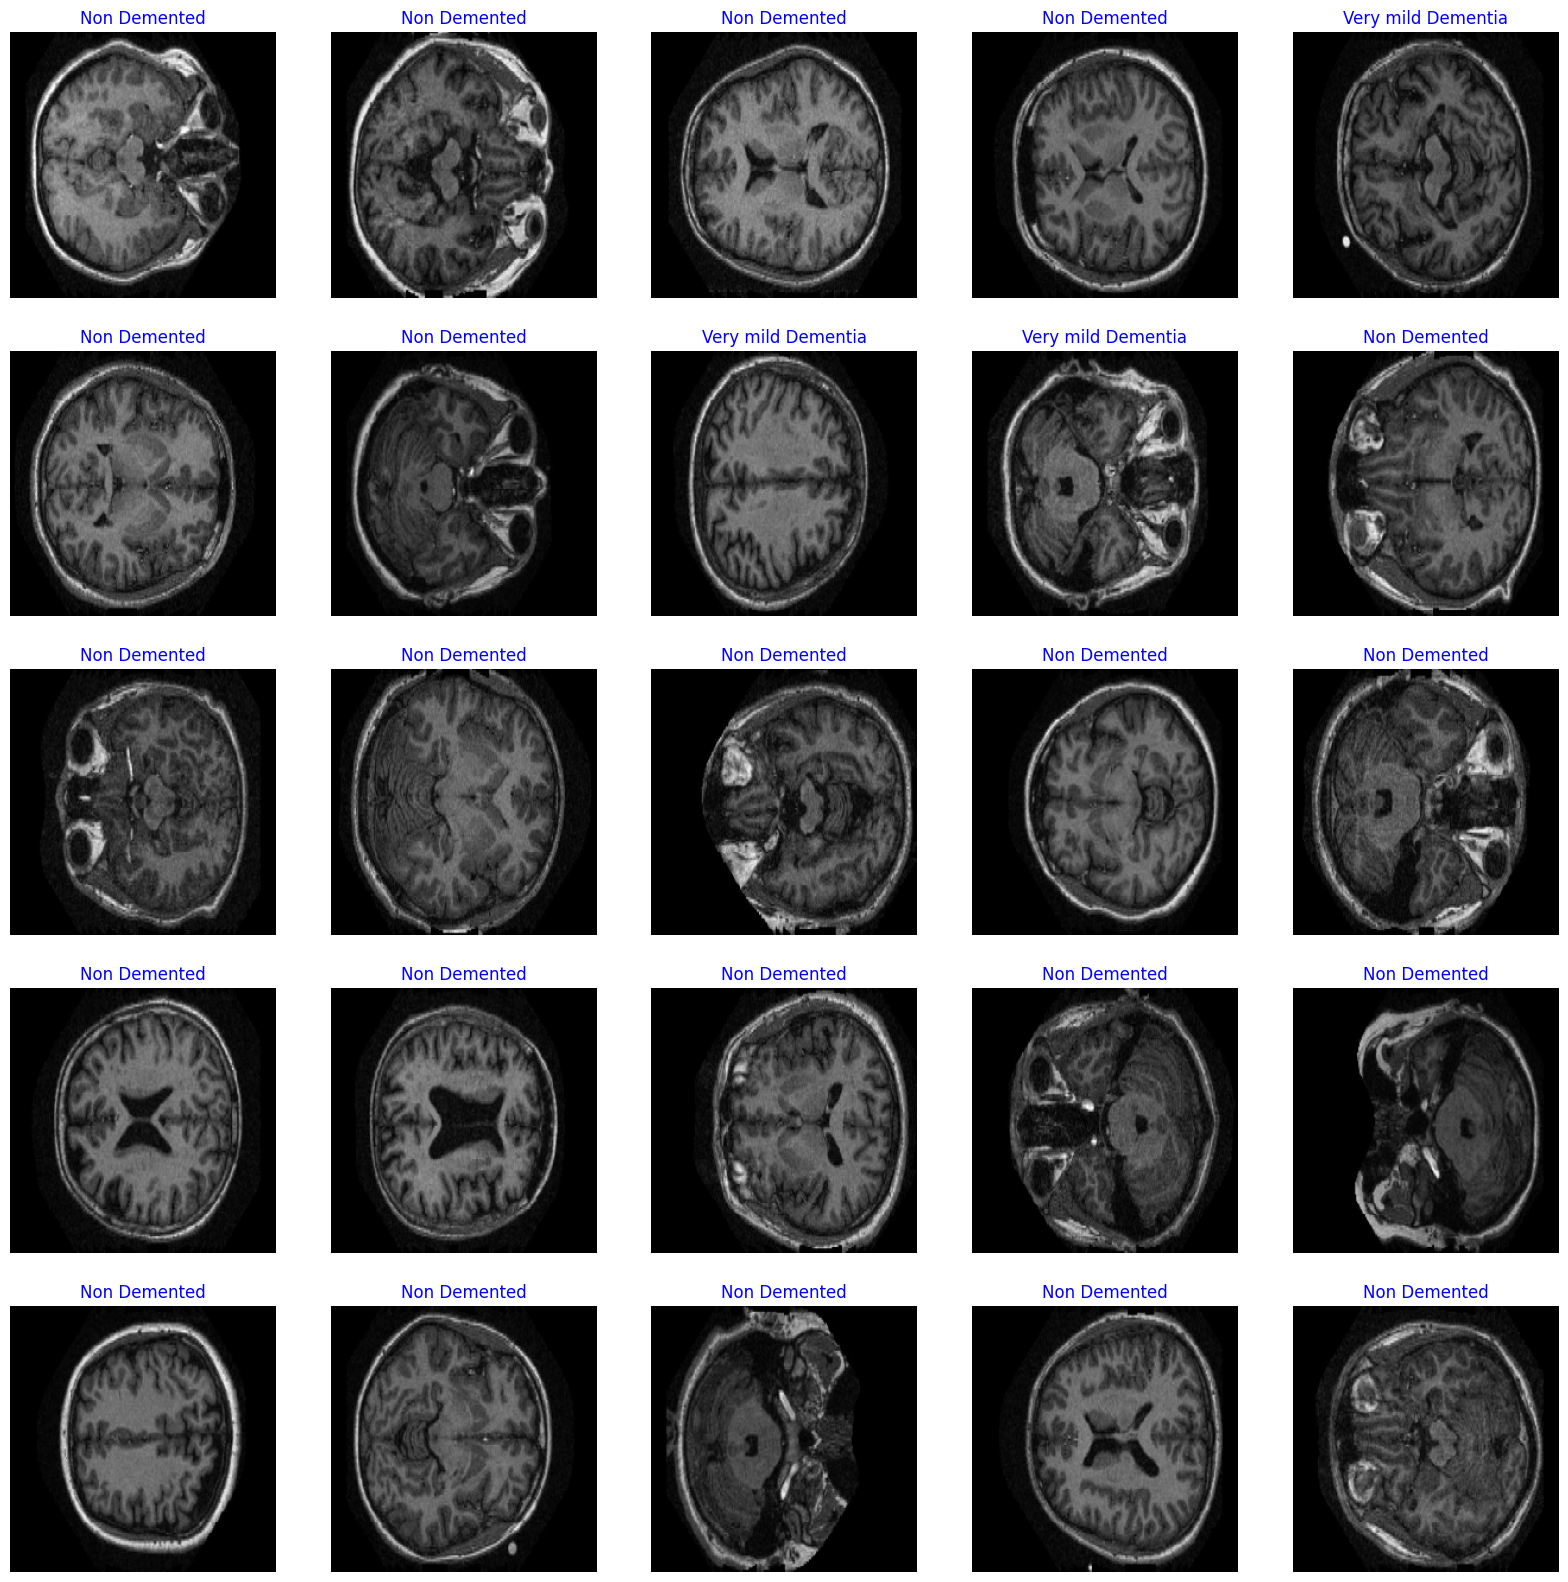

In [12]:
show_image(train_gen)

# Creating Model: CNN

In [13]:
IMAGE_SIZE = 224
BATCH_SIZE = 32

In [14]:
model = keras.Sequential([
Conv2D(filters=64, kernel_size=(3,3),padding="same",
activation='relu', input_shape= (IMAGE_SIZE,IMAGE_SIZE,3)),
Conv2D(filters=64, kernel_size=(3,3),padding="same",
activation='relu', input_shape= (IMAGE_SIZE,IMAGE_SIZE,3)),
MaxPooling2D(pool_size=(2,2)),
Conv2D(filters=128, kernel_size=(3,3),padding="same",
activation='relu', input_shape= (IMAGE_SIZE,IMAGE_SIZE,3)),
Conv2D(filters=128, kernel_size=(3,3),padding="same",
activation='relu', input_shape= (IMAGE_SIZE,IMAGE_SIZE,3)),
MaxPooling2D(pool_size=(2,2)),
Conv2D(filters=256, kernel_size=(3,3),padding="same",
activation='relu', input_shape= (IMAGE_SIZE,IMAGE_SIZE,3)),
MaxPooling2D(pool_size=(2, 2)),
Flatten(),
Dropout(0.4),
Dense(256,activation='relu'),
Dense(128,activation='relu'),
Dense(64,activation='relu'),
Dense(4, activation='softmax',
dtype='float32')
])


In [15]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
loss='categorical_crossentropy',metrics=['accuracy'])
          
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 64)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                    

In [16]:
callbacks = [
EarlyStopping(
monitor='val_loss',
patience=5,
restore_best_weights=True),
    
ModelCheckpoint(
filepath='CCN.h5',
monitor='val_loss',
save_best_only=True,
save_weights_only=False,
mode='min',
verbose=1),

keras.callbacks.ReduceLROnPlateau(
monitor='val_loss',
factor=0.5,
patience=3,
min_lr=1e-7,
verbose=1)]

In [22]:
epochs = 20
history = model.fit(train_gen,epochs= epochs,
validation_data = test_gen,callbacks = callbacks)

Epoch 1/20
1729/1729 [==============================] - ETA: 0s - loss: 0.2379 - accuracy: 0.9103

KeyboardInterrupt: 

In [ ]:
#Plotting training and validation loss and accuracy
plt.figure(figsize=(12, 5))
# ￿ Loss
plt.subplot(1, 2, 1)
plt.plot(cnn_history.history['loss'], label='Train Loss', marker='o',color='blue')
plt.plot(cnn_history.history['val_loss'], label='Val Loss', marker='o',color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# ￿ Accuracy
plt.subplot(1, 2, 2)
plt.plot(cnn_history.history['accuracy'], label='Train Accuracy', marker='o',color='red')
plt.plot(cnn_history.history['val_accuracy'], label='Val Accuracy', marker='o',color='green')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()
10

# Accuracy and Prediction

In [ ]:
pred_probs = model.predict(test_gen, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)

In [ ]:
y_true = test_gen.classes

In [ ]:
# Classification report
target_names = list(test_gen.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from matplotlib.pyplot import imshow
# Load and preprocess the image
img_path = '/kaggle/input/imagesoasis/Data/Moderate Dementia/OAS1_0308_MR1_mpr-1_101.jpg'
img = Image.open(img_path).convert('RGB')  # Ensure 3 channels
img_resized = img.resize((128, 128))
x = np.array(img_resized) / 255.0  # normalize if model was trained that way
x = x.reshape(1, 128, 128, 3)

# Predict
res = model.predict_on_batch(x)
pred_class_idx = np.argmax(res)
confidence = res[0][pred_class_idx] * 100

# Map index to class label
class_labels = list(test_gen.class_indices.keys())  # or use train_gen if test_gen not loaded
predicted_class = class_labels[pred_class_idx]

# Display
plt.imshow(img)
plt.axis('off')
plt.title(f"{confidence:.2f}% Confidence This is {predicted_class}")
plt.show()

In [ ]:
# Load and preprocess the image
img_path = '/kaggle/input/imagesoasis/Data/Very mild Dementia/OAS1_0003_MR1_mpr-1_117.jpg'
img = Image.open(img_path).convert('RGB')  # Ensure 3 channels
img_resized = img.resize((128, 128))
x = np.array(img_resized) / 255.0  # normalize if model was trained that way
x = x.reshape(1, 128, 128, 3)

# Predict
res = model.predict_on_batch(x)
pred_class_idx = np.argmax(res)
confidence = res[0][pred_class_idx] * 100

# Map index to class label
class_labels = list(test_gen.class_indices.keys())  # or use train_gen if test_gen not loaded
predicted_class = class_labels[pred_class_idx]

# Display
plt.imshow(img)
plt.axis('off')
plt.title(f"{confidence:.2f}% Confidence This is {predicted_class}")
plt.show()

In [ ]:
# Load and preprocess the image
img_path = '/kaggle/input/imagesoasis/Data/Mild Dementia/OAS1_0028_MR1_mpr-1_145.jpg'
img = Image.open(img_path).convert('RGB')  # Ensure 3 channels
img_resized = img.resize((128, 128))
x = np.array(img_resized) / 255.0  # normalize if model was trained that way
x = x.reshape(1, 128, 128, 3)

# Predict
res = model.predict_on_batch(x)
pred_class_idx = np.argmax(res)
confidence = res[0][pred_class_idx] * 100

# Map index to class label
class_labels = list(test_gen.class_indices.keys())  # or use train_gen if test_gen not loaded
predicted_class = class_labels[pred_class_idx]

# Display
plt.imshow(img)
plt.axis('off')
plt.title(f"{confidence:.2f}% Confidence This is {predicted_class}")
plt.show()

In [ ]:
class_labels = list(test_gen.class_indices.keys())

# Get image filepaths (to load and show images)
filepaths = test_gen.filepaths

# Show 8 predictions with actual labels
count = 0
fig, ax = plt.subplots(4, 2)
fig.set_size_inches(10, 10)

for i in range(4):
    for j in range(2):
        index = count
        img = plt.imread(filepaths[index])
        
        predicted_label = class_labels[y_pred[index]]
        actual_label = class_labels[y_true[index]]

        ax[i, j].imshow(img)
        ax[i, j].set_title(f"Predicted: {predicted_label}\nActual: {actual_label}")
        ax[i, j].axis('off')
        
        count += 1

plt.tight_layout()
plt.show()